In [1]:
import scipy.io.wavfile as wav
import numpy as np
from scipy.signal.windows import hamming
from scipy.fft import fft
import matplotlib.pyplot as plt

# Load the audio file
sampling_rate, signal = wav.read('/content/signal.wav')

# Display information
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Number of samples: {len(signal)}")
print(f"Duration: {len(signal) / sampling_rate} seconds")


Sampling rate: 16000 Hz
Number of samples: 18091
Duration: 1.1306875 seconds


In [2]:
# Compute the mean of the signal
x0 = signal.mean()

# Subtract the mean from the signal to get x2
x2 = signal - x0

In [3]:
#set b
b = 0.97

# Apply the pre-emphasis filter
x3 = np.append(x2[0], x2[1:] - b * x2[:-1])

In [28]:
def compute_frames(signal, L, S):
    """
    ompute a series of 𝑁𝑓 frames.

    Parameters:
    - signal: The input signal
    - L: Frame length (window length) in samples
    - S: Frame shift (hop size) in samples

    Returns:
    - A matrix where each row is a frame. Size of matrix is 𝑁𝑓 x L, where 𝑁𝑓 is the number of frames.
    """

    # Determine if padding is necessary for the last frame
    leftover_samples = (len(signal) - L) % S
    padding_required = 0 if leftover_samples == 0 else 1

    # Calculate the total number of frames considering padding
    num_frames = (len(signal) - L) // S + 1 + padding_required

    # Create a matrix to hold the frames
    frames = np.zeros((num_frames, L))

    for k in range(num_frames):
        frame = signal[k*S : k*S + L]
        frames[k, :len(frame)] = frame

    return frames

# test the function with default parameters L = 400 and S = 160 (which correspond to 25ms and 10ms respectively for a 16kHz signal):
window_duration = 0.025
shift_duration = 0.01
L_default = int(window_duration * sampling_rate)
S_default = int(shift_duration * sampling_rate)
print('For a window duration:', str(window_duration), 'the value of L =', str(L_default))
print('For a shift duration:', str(shift_duration), 'the value of S =', str(S_default))
xk = compute_frames(x3, L_default, S_default)

For a window duration: 0.025 the value of L = 400
For a shift duration: 0.01 the value of S = 160


In [29]:
def apply_hamming_window(frame):
    """
    Apply the Hamming window to a frame.

    Parameters:
    - frame: A single frame (1D numpy array)

    Returns:
    - Windowed frame (1D numpy array of the same length as the input frame)
    """

    # Create the Hamming window of the same length as the frame
    window = hamming(len(frame))

    # Element-wise multiplication of the frame and the window
    windowed_frame = frame * window

    return windowed_frame

# Define shape of windowed frames
xk_w = np.zeros_like(xk)

for frame in range(xk.shape[0]):
  xk_w[frame] = apply_hamming_window(xk[frame])

In [30]:
def compute_fft(windowed_frame, N=512):
    """
    Compute the Fourier transform of a windowed frame.

    Parameters:
    - windowed_frame: The input windowed frame (1D numpy array)
    - N: The number of DFT points (default is 512)

    Returns:
    - The Fourier transform of the frame (1D numpy array of length N)
    """

    return fft(windowed_frame, n=N)

# Compute FFT of windowed frames
xk_w_fft = []
for frame in range(xk.shape[0]):
  xk_w_fft.append(compute_fft(xk_w[frame]))

xk_w_fft = np.array(xk_w_fft)

In [31]:
def compute_magnitude_power(fft_values):
    """
    Compute the magnitude and power spectra from the FFT values.

    Parameters:
    - fft_values: The FFT values (1D numpy array)

    Returns:
    - magnitude_spectrum: Magnitude spectrum (1D numpy array of the same length as fft_values)
    - power_spectrum: Power spectrum (1D numpy array of the same length as fft_values)
    """

    # Compute the magnitude spectrum
    magnitude_spectrum = np.abs(fft_values)

    # Compute the power spectrum
    power_spectrum = magnitude_spectrum ** 2

    return magnitude_spectrum, power_spectrum

# compute magnitude and then power
magnitude_spectrum = []
power_spectrum = []
for frame in range(xk_w_fft.shape[0]):
  magnitude, power = compute_magnitude_power(xk_w_fft[frame])
  magnitude_spectrum.append(magnitude)
  power_spectrum.append(power)

magnitude_spectrum = np.array(magnitude_spectrum)
power_spectrum = np.array(power_spectrum)


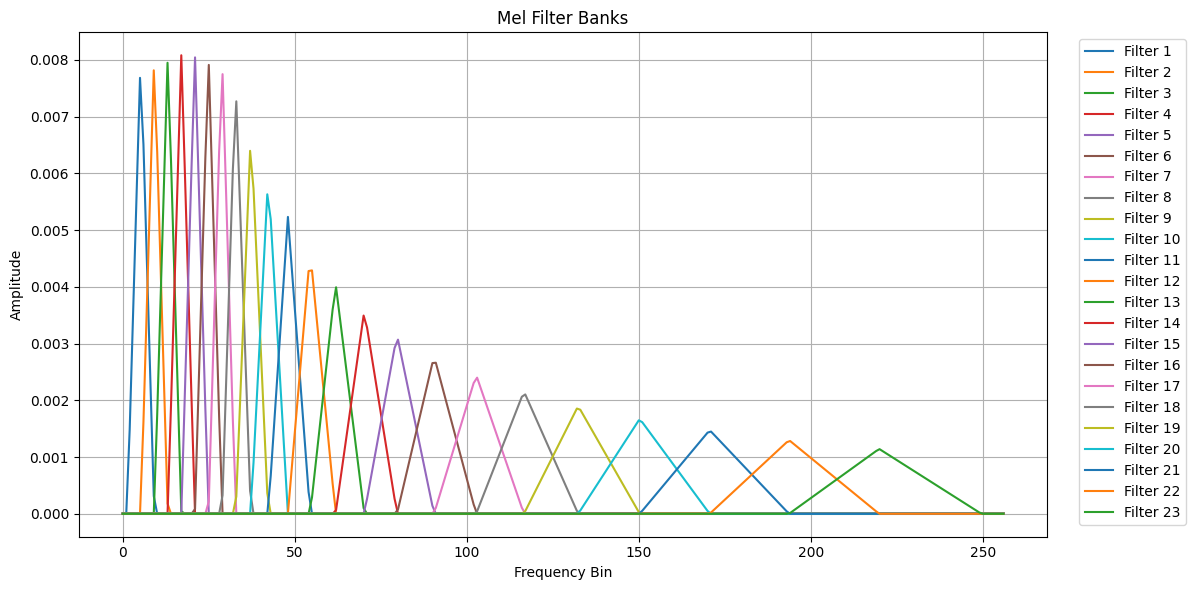

In [32]:
# Load mel filters
mel_filters = np.load('/content/mel_filters.npy')

# Plot mel filters
plt.figure(figsize=(12, 6))
for i, filter_curve in enumerate(mel_filters):
    plt.plot(filter_curve, label=f'Filter {i+1}')
plt.title('Mel Filter Banks')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
def apply_mel_filterbank(power_spectrum, mel_filters):
    """
    Apply Mel-filterbank to the power spectrum.

    Parameters:
    - power_spectrum: Power spectrum values (1D numpy array)
    - mel_filters: Mel filter banks (2D numpy array)

    Returns:
    - Mel-filterbank energies (1D numpy array)
    """

    # Matrix multiplication to get Mel-filterbank energies
    mel_energies = np.dot(mel_filters, power_spectrum)

    return mel_energies

# compute mel-filtered signal
mel_energies = []
for frame in range(power_spectrum.shape[0]):
  mel_energy = apply_mel_filterbank(power_spectrum[frame,:257], mel_filters)
  mel_energies.append(mel_energy)

In [34]:
def compute_log_mel(mel_energies):
    """
    Compute the logarithm of Mel-filterbank energies.

    Parameters:
    - mel_energies: Mel-filterbank energies (N-D numpy array)

    Returns:
    - Logarithm of the Mel-filterbank energies (1D numpy array)
    """

    # Compute the logarithm and clip values at -50
    log_mel_energies = np.maximum(-50, np.log(mel_energies))

    return log_mel_energies

# compute log-Mel
log_mel = compute_log_mel(mel_energies)

In [35]:
def compute_dct(log_mel_energies, num_coeffs=13):
    """
    Compute the DCT of log-Mel energies using the given equation.

    Parameters:
    - log_mel_energies: Log-Mel energies (1D numpy array)
    - num_coeffs: Number of DCT coefficients to retain

    Returns:
    - DCT coefficients (1D numpy array of length num_coeffs)
    """

    N = len(log_mel_energies)
    coefficients = []

    for i in range(num_coeffs):
        coeff = sum([log_mel_energies[k] * np.cos(np.pi * i / N * (k + 0.5)) for k in range(N)])
        coefficients.append(coeff)

    return np.array(coefficients)

# compute the DCT
DCT = []
for i in range(log_mel.shape[0]):
  DCT_coefficients = compute_dct(log_mel[i])
  DCT.append(DCT_coefficients)

DCT = np.array(DCT)

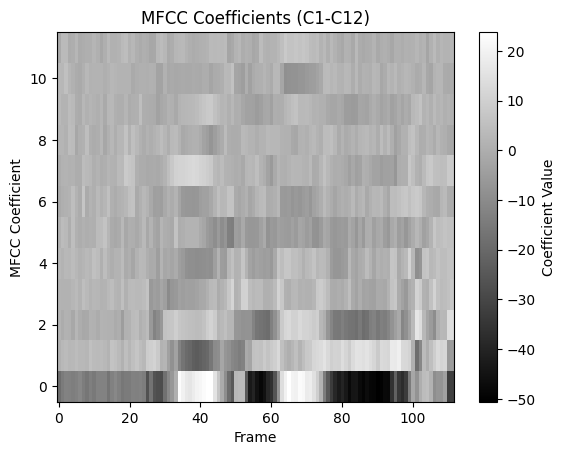


Mean Squared Error (MSE) between the MFCC matrices: 0.0000



In [36]:
# Exclude C0 for the visualization
plt.imshow(DCT[:, 1:].T, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Coefficient Value')
plt.ylabel('MFCC Coefficient')
plt.xlabel('Frame')
plt.title('MFCC Coefficients (C1-C12)')
plt.show()

# To compute the difference between your MFCCs and the reference MFCCs. This can only be done when number of frames is 112.
if DCT.shape[0] == 112:
  reference_mfccs = np.load('/content/reference_mfcc.npy')
  diff = DCT - reference_mfccs

  # Compute the Mean Squared Error (MSE) between the two matrices
  mse = np.mean(diff**2)

  print(f"\nMean Squared Error (MSE) between the MFCC matrices: {mse:.4f}\n")


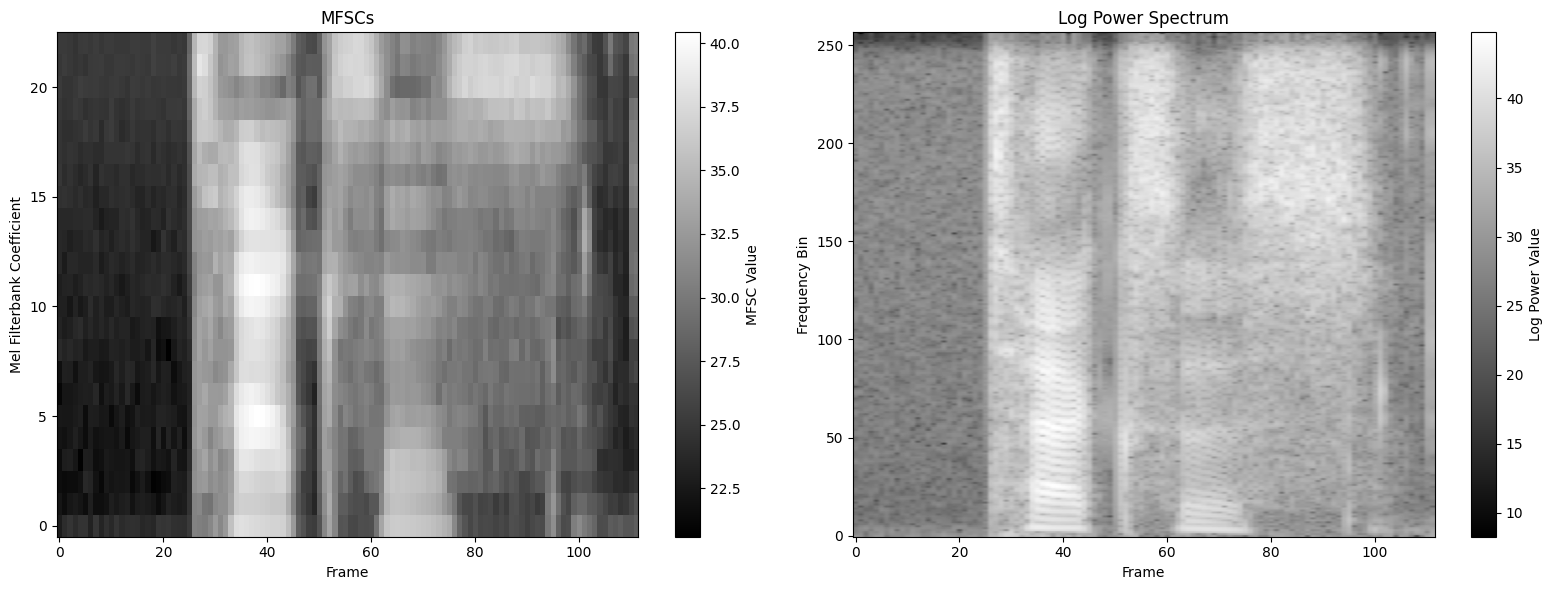

In [37]:
# Plot MFSCs
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(log_mel.T, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='MFSC Value')
plt.title('MFSCs')
plt.xlabel('Frame')
plt.ylabel('Mel Filterbank Coefficient')

# Plot Log Power Spectrum
log_power_spectrum = np.maximum(-50, np.log(power_spectrum[:, :257]))

plt.subplot(1, 2, 2)
plt.imshow(log_power_spectrum.T, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Log Power Value')
plt.title('Log Power Spectrum')
plt.xlabel('Frame')
plt.ylabel('Frequency Bin')

plt.tight_layout()
plt.show()


# Effects of Mel-Filtering

**Frequency Warping**:
In the MFSCs, the Mel-scale warps the frequencies to better match human hearing perception. This results in a higher resolution in the lower frequencies and a lower resolution in the higher frequencies. The log power spectrum, on the other hand, has a uniform frequency resolution across the spectrum.

**Frequency Compression**:
The Mel-scale also compresses the entire frequency range into fewer bands (23 Mel bands in this case). This effectively reduces the resolution of the high frequencies while increasing the resolution of the low frequencies.

**Energy Distribution**:
The Mel filterbanks will lump energy from certain frequency bands together, so the energy distribution across the spectrum will look different between the MFSCs and the log power spectrum.

## Log Mel-filterbank Energies (MFSCs) vs Log Power Spectrum

**Log Mel-filterbank Energies (MFSCs)**:
This spectrum is derived from the power spectrum after applying Mel-filterbanks. It captures the energy in different Mel-frequency bands and is more aligned with human perception of frequency.

**Log Power Spectrum**:
This spectrum represents the raw power spectrum without any Mel-filterbank application. It simply captures the energy in different frequency bins.

**Differences between the two spectra**:

- The MFSCs are smoother, showing broader frequency bands, while the log power spectrum has much finer details.
- The MFSCs are more representative of how humans perceive sound, focusing on certain frequency regions more than others, whereas the log power spectrum provides a direct view of the signal's frequency content.


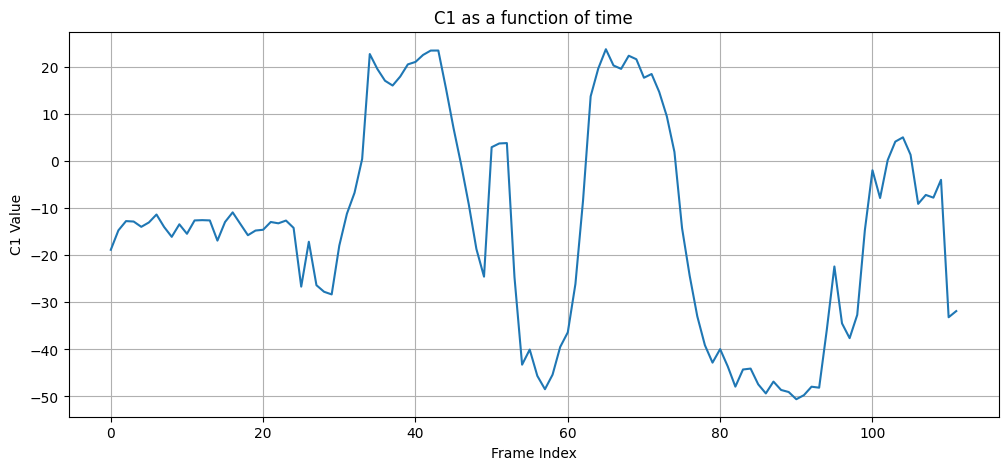

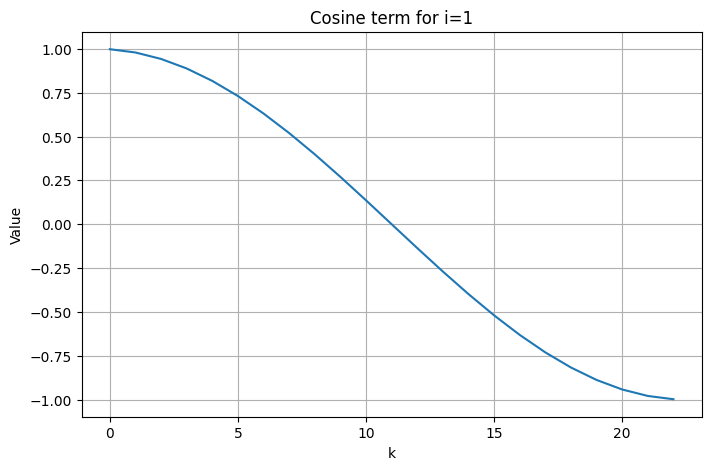

In [38]:
# Assuming C is DCT coefficients[] matrix
C1 = DCT[:, 1]

# Plot C1 as a function of time
plt.figure(figsize=(12, 5))
plt.plot(C1)
plt.title("C1 as a function of time")
plt.xlabel("Frame Index")
plt.ylabel("C1 Value")
plt.grid(True)
plt.show()

# Plot the cosine term for i = 1
k = np.arange(23)  # 23 Mel-filterbanks
cosine_term = np.cos(np.pi * 1 / 23 * (k + 0.5))

plt.figure(figsize=(8, 5))
plt.plot(k, cosine_term)
plt.title("Cosine term for i=1")
plt.xlabel("k")
plt.ylabel("Value")
plt.grid(True)
plt.show()


When we look at the DCT, especially for the first coefficient C1, the cosine term weights the Mel-scale log power spectrum. Given the shape of the cosine function for i=1, it's most positive (and close to 1) for the lower frequency components and decreases as frequency increases.

Vowels, being voiced sounds, have a rich harmonic structure that is concentrated in the lower frequencies. These harmonics, or formants, give vowels their characteristic sounds. On the other hand, fricatives are largely unvoiced sounds, characterized by turbulent airflow and noise, resulting in higher frequency energy.

When we compute C1, it predominantly captures the energy in the lower frequencies because of the weighting from the cosine term. Thus, during vowels, C1 will be higher since it's capturing the energy-rich low frequencies of the vowels. Conversely, during fricatives, C1 will be lower since the high-frequency noise of fricatives gets less weight. This is clearly observable in the plot of C1 value vs time/frame_index.

For a window duration: 0.004 the value of L = 64
For a shift duration: 0.001 the value of S = 16


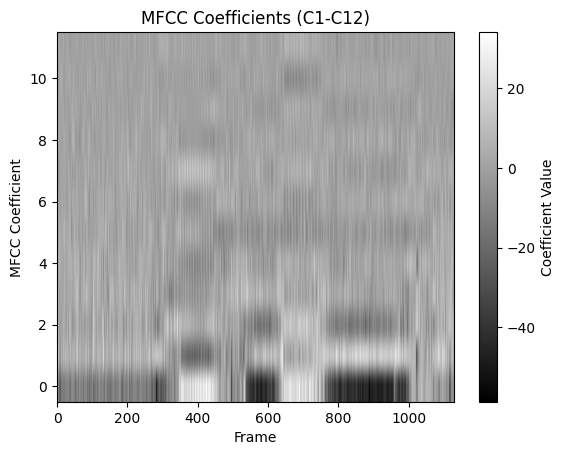

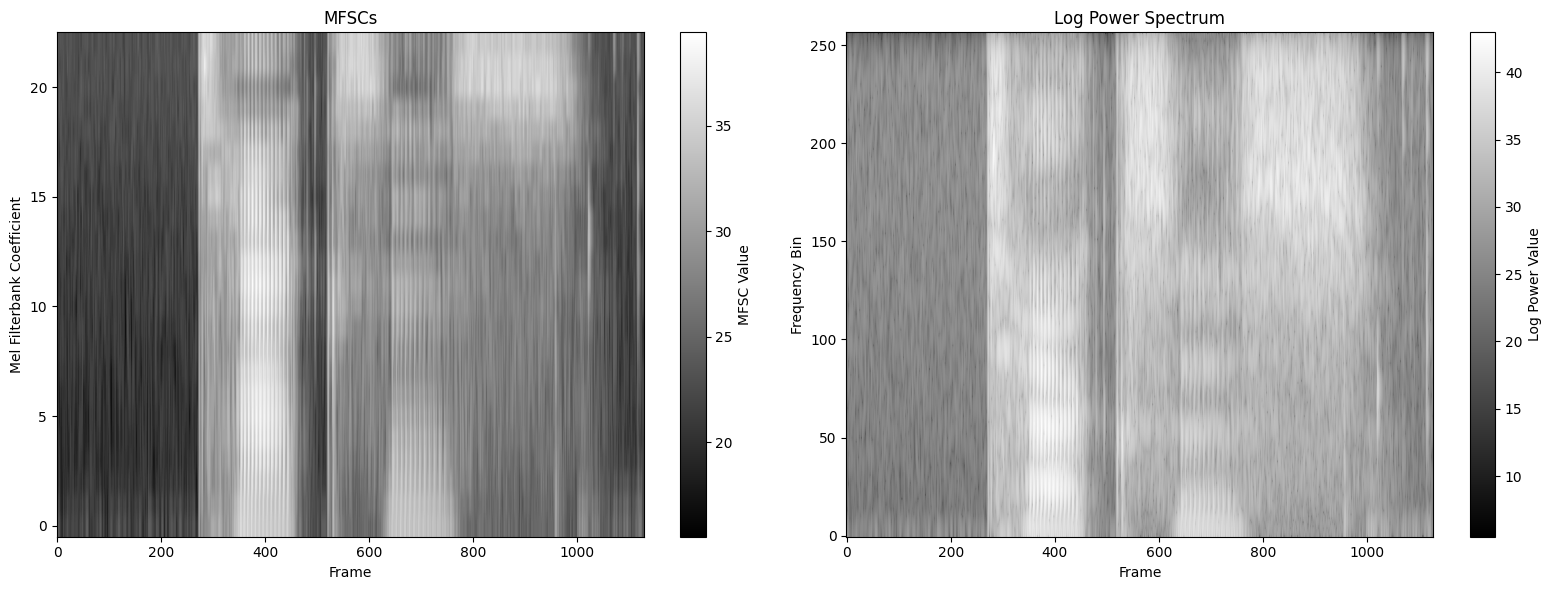

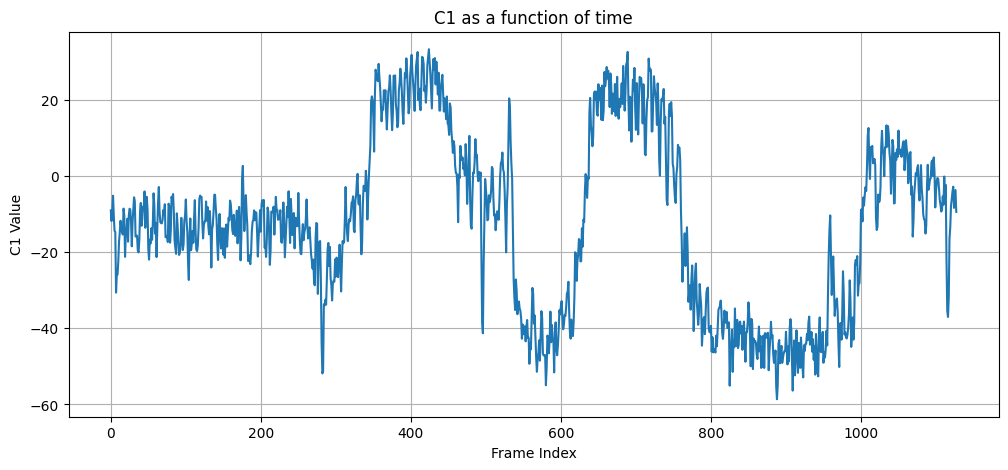

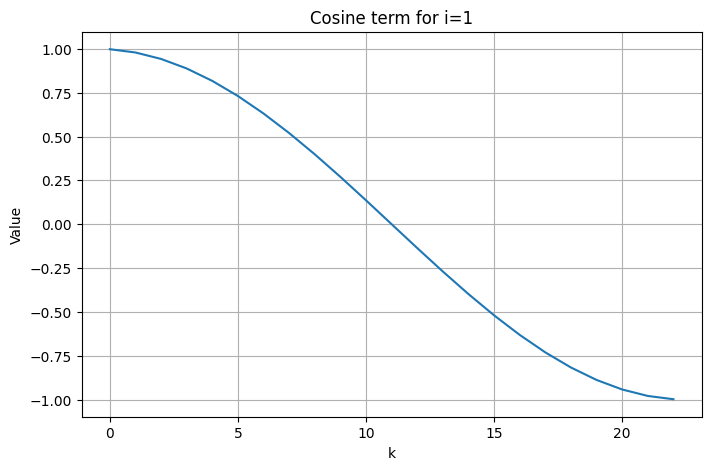

In [39]:
# test the function with default parameters L = 400 and S = 160 (which correspond to 25ms and 10ms respectively for a 16kHz signal):
window_duration = 0.004
shift_duration = 0.001
L_default = int(window_duration * sampling_rate)
S_default = int(shift_duration * sampling_rate)
print('For a window duration:', str(window_duration), 'the value of L =', str(L_default))
print('For a shift duration:', str(shift_duration), 'the value of S =', str(S_default))
xk = compute_frames(x3, L_default, S_default)

# Define shape of windowed frames
xk_w = np.zeros_like(xk)

for frame in range(xk.shape[0]):
  xk_w[frame] = apply_hamming_window(xk[frame])

# Compute FFT of windowed frames
xk_w_fft = []
for frame in range(xk.shape[0]):
  xk_w_fft.append(compute_fft(xk_w[frame]))

xk_w_fft = np.array(xk_w_fft)

# compute magnitude and then power
magnitude_spectrum = []
power_spectrum = []
for frame in range(xk_w_fft.shape[0]):
  magnitude, power = compute_magnitude_power(xk_w_fft[frame])
  magnitude_spectrum.append(magnitude)
  power_spectrum.append(power)

magnitude_spectrum = np.array(magnitude_spectrum)
power_spectrum = np.array(power_spectrum)

# Load mel filters
mel_filters = np.load('/content/mel_filters.npy')

# Plot mel filters
# plt.figure(figsize=(12, 6))
# for i, filter_curve in enumerate(mel_filters):
#     plt.plot(filter_curve, label=f'Filter {i+1}')
# plt.title('Mel Filter Banks')
# plt.xlabel('Frequency Bin')
# plt.ylabel('Amplitude')
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# compute mel-filtered signal
mel_energies = []
for frame in range(power_spectrum.shape[0]):
  mel_energy = apply_mel_filterbank(power_spectrum[frame,:257], mel_filters)
  mel_energies.append(mel_energy)

# compute log-Mel
log_mel = compute_log_mel(mel_energies)

# compute the DCT
DCT = []
for i in range(log_mel.shape[0]):
  DCT_coefficients = compute_dct(log_mel[i])
  DCT.append(DCT_coefficients)

DCT = np.array(DCT)

# Exclude C0 for the visualization
plt.imshow(DCT[:, 1:].T, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Coefficient Value')
plt.ylabel('MFCC Coefficient')
plt.xlabel('Frame')
plt.title('MFCC Coefficients (C1-C12)')
plt.show()

# To compute the difference between your MFCCs and the reference MFCCs. This can only be done when number of frames is 112.
if DCT.shape[0] == 112:
  reference_mfccs = np.load('/content/reference_mfcc.npy')
  diff = DCT - reference_mfccs

  # Compute the Mean Squared Error (MSE) between the two matrices
  mse = np.mean(diff**2)
  print(f"Mean Squared Error (MSE) between the MFCC matrices: {mse:.4f}")

# Plot MFSCs
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(log_mel.T, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='MFSC Value')
plt.title('MFSCs')
plt.xlabel('Frame')
plt.ylabel('Mel Filterbank Coefficient')

# Plot Log Power Spectrum
log_power_spectrum = np.maximum(-50, np.log(power_spectrum[:, :257]))
plt.subplot(1, 2, 2)
plt.imshow(log_power_spectrum.T, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Log Power Value')
plt.title('Log Power Spectrum')
plt.xlabel('Frame')
plt.ylabel('Frequency Bin')

plt.tight_layout()
plt.show()

# Assuming C is DCT coefficients[] matrix
C1 = DCT[:, 1]

# Plot C1 as a function of time
plt.figure(figsize=(12, 5))
plt.plot(C1)
plt.title("C1 as a function of time")
plt.xlabel("Frame Index")
plt.ylabel("C1 Value")
plt.grid(True)
plt.show()

# Plot the cosine term for i = 1
k = np.arange(23)  # 23 Mel-filterbanks
cosine_term = np.cos(np.pi * 1 / 23 * (k + 0.5))

plt.figure(figsize=(8, 5))
plt.plot(k, cosine_term)
plt.title("Cosine term for i=1")
plt.xlabel("k")
plt.ylabel("Value")
plt.grid(True)
plt.show()

With a smaller window, we achieved enhanced temporal resolution, though at the expense of blurring the harmonics. Conversely, a larger window provided improved frequency resolution, but the trade-off was a diminished clarity in the temporal information.